# Notebook de visualisation
Basé sur la Logistic Regression

In [4]:
import findspark

findspark.init()
import pyspark
import time
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from datetime import datetime

## Initialisation des variables contexte

In [5]:
spark1 = SparkSession.builder \
    .master("local[*]") \
    .appName("ROC_Twitter") \
    .getOrCreate()

path = "../resources/training_noemoticon.csv"

schema = StructType([
    StructField("target", IntegerType(), True),
    StructField("id", StringType(), True),
    StructField("date", StringType(), True),
    StructField("query", StringType(), True),
    StructField("author", StringType(), True),
    StructField("tweet", StringType(), True)])

## Importation du dataset

In [6]:
df = spark1.read.csv(path,
                     inferSchema=True,
                     header=False,
                     schema=schema)

df.dropna()

DataFrame[target: int, id: string, date: string, query: string, author: string, tweet: string]

## Séparation train/test

In [7]:
(train_set, test_set) = df.randomSplit([0.80, 0.20])

## HashingTF - IDF (paramètres par défaut)

In [8]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, lr])

In [9]:
st = datetime.utcnow()
pipelineFit1 = pipeline.fit(train_set)
print('Training time:', datetime.utcnow() - st)

predictions = pipelineFit1.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Training time: 0:01:04.398198
Accuracy: 0.7333285379652419
Precision: 0.7333396937421737
Recall: 0.7333285379652419


## HashingTF - IDF (paramètres customisés)

In [10]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, lr])

In [11]:
st = datetime.utcnow()

pipelineFit2 = pipeline.fit(train_set)
print('Training time:', datetime.utcnow() - st)

predictions = pipelineFit2.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Training time: 0:00:24.428012
Accuracy: 0.7759739548964357
Precision: 0.7760807380927519
Recall: 0.7759739548964357


## CountVectorizer - IDF (paramètres par défaut)

In [12]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

In [13]:
st = datetime.utcnow()

pipelineFit3 = pipeline.fit(train_set)
print('Training time:', datetime.utcnow() - st)

predictions = pipelineFit3.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Training time: 0:04:49.865223
Accuracy: 0.7649967318523986
Precision: 0.765029311917214
Recall: 0.7649967318523986


## CountVectorizer - IDF (paramètres customisés)

In [14]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

In [15]:
st = datetime.utcnow()

pipelineFit4 = pipeline.fit(train_set)
print('Training time:', datetime.utcnow() - st)

predictions = pipelineFit4.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Training time: 0:01:20.417225
Accuracy: 0.7922615268660498
Precision: 0.7925083261570012
Recall: 0.7922615268660498


## Assemblage de la pipeline
Comprend : CountVectorizer + IDF + NGram + ChisQSelector

In [16]:
def build_trigrams(inputCol=["tweet", "target"], n=3):
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]

    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2 ** 14, inputCol="{0}_grams".format(i),
                        outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]

    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]

    label_stringIdx = [StringIndexer(inputCol="target", outputCol="label")]

    selector = [ChiSqSelector(numTopFeatures=2 ** 14, featuresCol='rawFeatures', outputCol="features")]

    lr = [LogisticRegression()]

    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + lr)

## Entrainement du modèle et évaluation

In [17]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

start = time.time()

# entrainement
pipelineFit5 = build_trigrams().fit(train_set)

# lancement des predictions
predictions = pipelineFit5.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

end = time.time()
print(end - start)

Accuracy: 0.8082269751964798
Precision: 0.8095927439971657
Recall: 0.8082269751964799
423.1274724006653


## Data visualisation

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

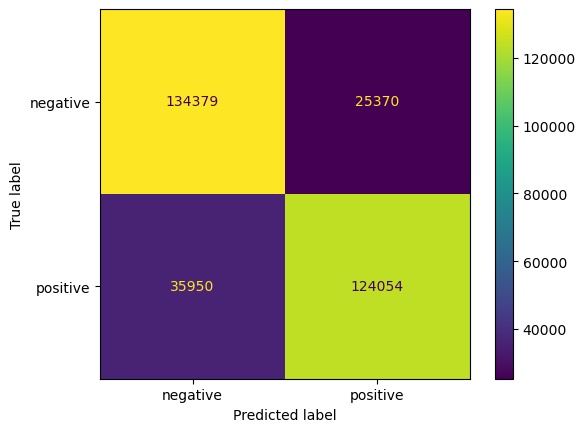

In [19]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

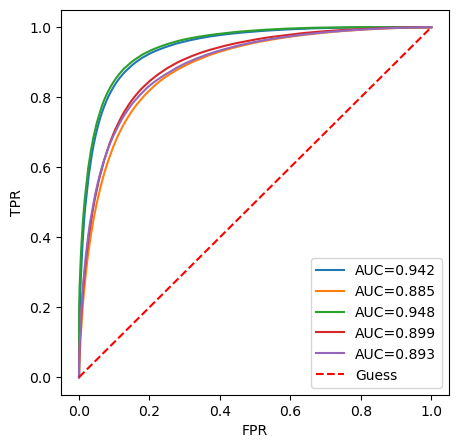

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

plt.plot(pipelineFit1.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit1.stages[-1].summary.roc.select('TPR').collect(),
        label="AUC=" +str(round(pipelineFit1.stages[-1].summary.areaUnderROC, 3)))

plt.plot(pipelineFit2.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit2.stages[-1].summary.roc.select('TPR').collect(),
        label="AUC=" +str(round(pipelineFit2.stages[-1].summary.areaUnderROC, 3)))

plt.plot(pipelineFit3.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit3.stages[-1].summary.roc.select('TPR').collect(),
        label="AUC=" +str(round(pipelineFit3.stages[-1].summary.areaUnderROC, 3)))

plt.plot(pipelineFit4.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit4.stages[-1].summary.roc.select('TPR').collect(),
        label="AUC=" +str(round(pipelineFit4.stages [-1].summary.areaUnderROC, 3)))


plt.plot(pipelineFit5.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit5.stages[-1].summary.roc.select('TPR').collect(),
        label="AUC=" +str(round(pipelineFit5.stages[-1].summary.areaUnderROC, 3)))

plt.plot([0, 1], [0, 1], "r--", label="Guess")

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()